In [2]:
#!pip install tensorflow
#!pip install tensorflow_hub
import os
import time
from PIL import Image
from skimage.transform import resize
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

  Using cached tensorflow-2.3.0-cp38-cp38-manylinux2010_x86_64.whl (320.5 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
Processing /home/jovyan/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73/wrapt-1.12.1-cp38-cp38-linux_x86_64.whl
  Using cached grpcio-1.30.0-cp38-cp38-manylinux2010_x86_64.whl (3.0 MB)
Processing /home/jovyan/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501/termcolor-1.1.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/1d/10/8e/2f79b924179ff1e6510933d63eb851bea01054fff262343b7a/absl_py-0.9.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Usi

In [5]:
IMAGE_PATH = "GOES.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

model = hub.load(SAVED_MODEL_PATH)

In [7]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [8]:
hr_image = preprocess_image(IMAGE_PATH)
lr_image = downscale_image(tf.squeeze(hr_image))

In [9]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
hr_image = tf.squeeze(hr_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 8.740278


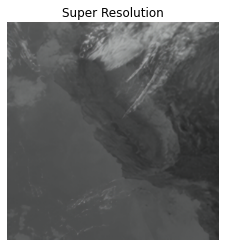

In [10]:
plot_image(tf.squeeze(fake_image), title = "Super Resolution")

In [11]:
hr_image.shape

TensorShape([556, 540, 3])

In [12]:
lr_image.shape

TensorShape([1, 139, 135, 3])

In [13]:
fake_image.shape

TensorShape([556, 540, 3])

In [17]:
fake_image = resize(fake_image, (556, 540, 3))

In [18]:
abs_error = abs(hr_image - fake_image)
np.max(abs_error), np.mean(abs_error), np.std(abs_error)

(56.439316, 2.0233338, 2.6378615)

In [19]:
np.sqrt(np.mean((hr_image - fake_image)**2))

3.3244839